# Lab 04 - Credit

---
embed-resources: true
---

## Introduction

Our bank currently relies on credit agencies to provide a credit rating for our potential customers. The purpose of this report is to cut out the middleman, the credit agencies, by formulating a credit score with the income and demographic information already provided to us by our potential customers on their loan applications.

## Methods

In [218]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import root_mean_squared_error

from joblib import dump

### Data

In [219]:
# load data
credit_train = pd.read_parquet("https://cs307.org/lab/data/credit-train.parquet")
credit_test = pd.read_parquet("https://cs307.org/lab/data/credit-test.parquet")

# create X and y for train
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# create X and y for test
X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]

This is simulated data from the textbook, *An Introduction to Statistical Learning*. The data dictionary is detailed below.

### Response
**`Rating`**
- [float64] credit rating, specifically the credit score of an individual consumer


### Features
**`Income`**
- [float64] yearly income in $1000s

**`Age`**
- [float64] age

**`Education`**
- [float64] years of education completed

**`Gender`**
- [object] gender

**`Student`**
- [object] a Yes / No variable with Yes indicating an individual is a student

**`Married`**
- [object] a Yes / No variable with Yes indicating an individual is married

**`Ethnicity`**
- [object] ethnicity


In [220]:
# summary statistics
credit_train

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
135,257.0,44.473,81.0,16.0,Female,No,No,None
277,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
93,388.0,16.479,26.0,16.0,Male,None,No,None
205,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
57,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian
...,...,...,...,...,...,...,...,...
290,268.0,26.370,78.0,11.0,Male,No,Yes,Asian
126,433.0,26.427,50.0,15.0,Female,Yes,Yes,Asian
105,259.0,12.031,58.0,18.0,Female,None,Yes,Caucasian
183,335.0,80.861,29.0,15.0,Female,No,Yes,Asian


This training dataset has 256 samples and 7 possible features.

In [221]:
print(f"Credit Rating Mean: {credit_train['Rating'].mean()}")
print(f"Credit Rating Std: {credit_train['Rating'].std()}")

Credit Rating Mean: 347.609375
Credit Rating Std: 148.8931046679028


We observe that the standard deviation in credit scores is quite large.

In [222]:
mean = credit_train[['Rating', 'Student']].groupby('Student').agg('mean').rename(columns={"Rating": "Rating Mean"})
std = credit_train[['Rating', 'Student']].groupby('Student').agg('std').rename(columns={"Rating": "Rating Std"})
count = credit_train[['Rating', 'Student']].groupby('Student').agg('count').rename(columns={"Rating": "Rating Count"})
pd.concat([mean, std, count], axis=1)

,Rating Mean,Rating Std,Rating Count
Student,,,
No,349.511737,148.003525,213
Yes,338.473684,149.164476,19


We observe that there is no major differences between credit ratings of students and non-students.

In [223]:
mean = credit_train[['Rating', 'Married']].groupby('Married').agg('mean').rename(columns={"Rating": "Rating Mean"})
std = credit_train[['Rating', 'Married']].groupby('Married').agg('std').rename(columns={"Rating": "Rating Std"})
count = credit_train[['Rating', 'Married']].groupby('Married').agg('count').rename(columns={"Rating": "Rating Count"})
pd.concat([mean, std, count], axis=1)

,Rating Mean,Rating Std,Rating Count
Married,,,
No,329.397959,132.039649,98
Yes,358.905063,157.797935,158


We observe that an average married person has a credit score about 30 points higher than the average unmarried person. But among married people, the standard deviation is also higher.

In [224]:
credit_train.corr(numeric_only=True)

,Rating,Income,Age,Education
Rating,1.000000,0.770842,0.143032,0.030147
Income,0.770842,1.000000,0.202098,0.033793
Age,0.143032,0.202098,1.000000,-0.011725
Education,0.030147,0.033793,-0.011725,1.000000


`Income` has the highest correlation with `Rating`, indicating that it will probably be very useful in the model. `Age` and `Education` have quite low correlations with `Income`.

In [225]:
credit_train.isna().sum() / len(credit_train)

Rating       0.000000
Income       0.000000
Age          0.128906
Education    0.097656
Gender       0.023438
Student      0.093750
Married      0.000000
Ethnicity    0.097656
dtype: float64

All data is intact for `Rating`, `Income`, and `Married`.  Around 10% or less of samples are missing a data point for `Age`, `Education`, `Gender`, `Student`, and `Ethnicity`.

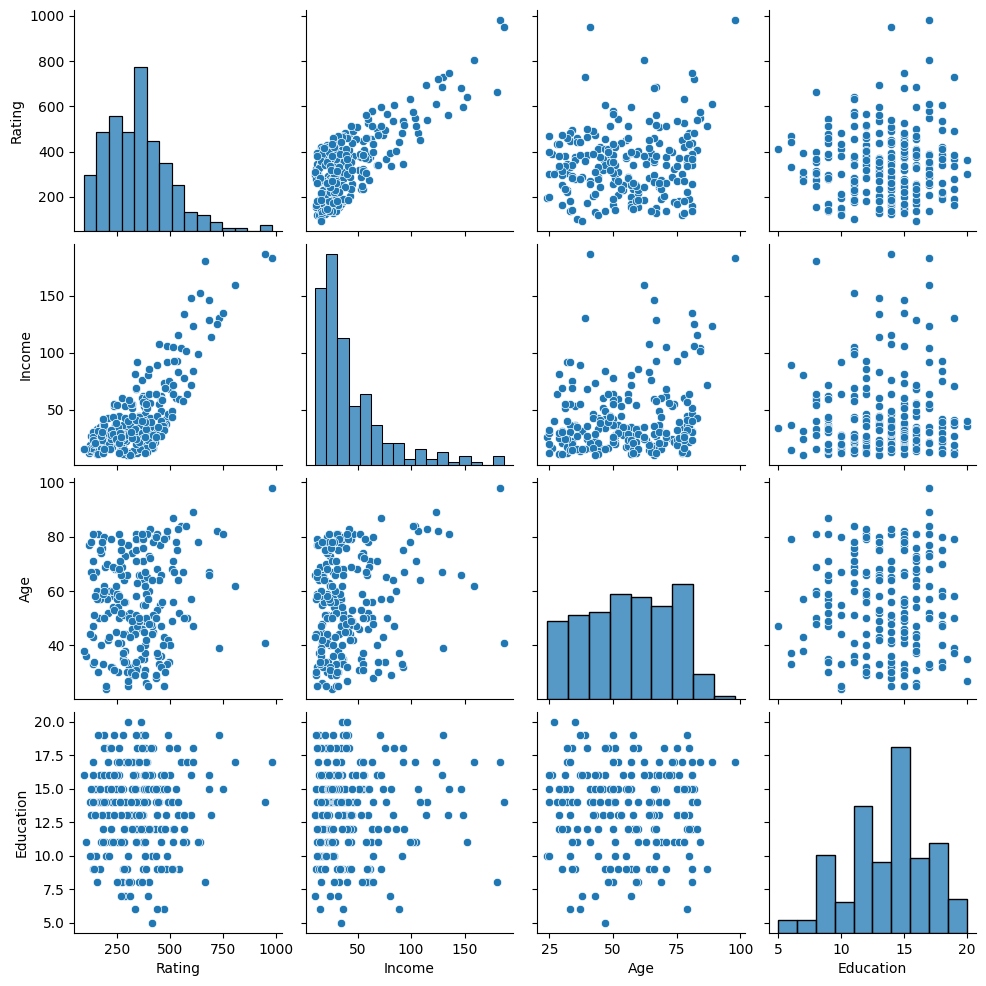

In [226]:
# exploratory visualization
sns.pairplot(credit_train)

Again, we observe that `Income` and `Rating` have the clearest relationship.

### Models

In [227]:
# process data for ML
numeric_features = ['Income']
categorical_features = ['Married']
features = numeric_features + categorical_features
target = 'Rating'

In [ ]:
numeric_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='infrequent_if_exist')
)

preprocessor = make_column_transformer(
    (numeric_pipeline, numeric_features),
    (categorical_pipeline, categorical_features),
)

For all numeric variables, we will impute missing values with the mean and then scale them. For all categorical variables we will impute missing values with the most frequent and then one-hot encode.

In [229]:
# train models
v_train, validation = train_test_split(credit_train)
x_v_train = v_train[features]
y_v_train = v_train[target]
x_validation = validation[features]
y_validation = validation[target]

param_grid = {
    "kneighborsregressor__n_neighbors": range(1, 50, 1),
    "kneighborsregressor__p": [1, 2],
}

pipeline = make_pipeline(
    preprocessor,
    KNeighborsRegressor()
)

model = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    refit=True,
)

_ = model.fit(x_v_train, y_v_train)

In [230]:
model.best_params_

{'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__p': 2}

In [231]:
model.best_score_

np.float64(-99.04533844666507)

In [232]:
# final model
final_model = make_pipeline(
    preprocessor,
    KNeighborsRegressor(n_neighbors=10, p=2)
)
_ = final_model.fit(credit_train[features], credit_train[target])

After parameter tuning with cross validation, the best model uses 10 neighbors and euclidean distance. It had an RMSE of 99.05. Now we train the model on the entire training set and evaluate on the test set.

## Results

In [233]:
# report model metrics
root_mean_squared_error(credit_test[target], final_model.predict(credit_test[features]))

101.7113555299997

The test RMSE is 101.71

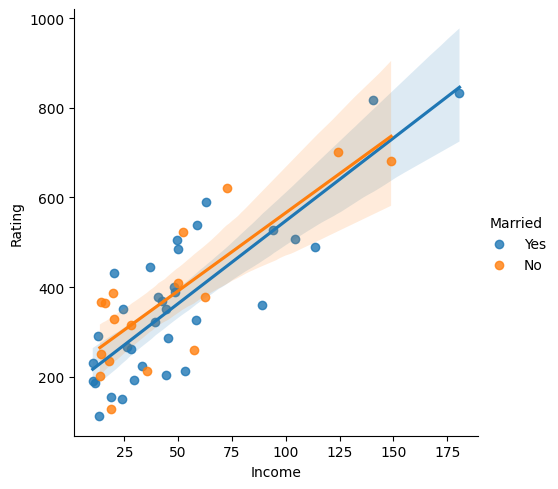

In [240]:
# summary figure
sns.lmplot(credit_test, x='Income', y='Rating', hue='Married')

In [235]:
# serialize model
dump(final_model, 'credit.joblib')

['credit.joblib']

## Discussion